# Interpolation, upsampling and smoothness

In [93]:
% matplotlib inline
import numpy as np
import math
import nibabel as nib
import scipy.stats as stats
import matplotlib.pyplot as plt
from nipy.labs.utils.simul_multisubject_fmri_dataset import surrogate_3d_dataset
import palettable.colorbrewer as cb
from nipype.interfaces import fsl
import os
import pandas as pd
import scipy.integrate as integrate
from scipy.misc import imresize
from nipype.interfaces.fsl.model import SmoothEstimate
import subprocess
import scipy

In [94]:
sm=1
smooth_FWHM = 6
smooth_sd = smooth_FWHM/(2.*math.sqrt(2.*math.log(2.)))
data = surrogate_3d_dataset(n_subj=1,sk=smooth_sd,shape=(100,100,100),noise_level=1)
mask = np.ones([100,100,100])

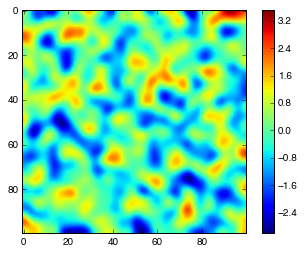

In [125]:
plt.figure(figsize=(6,4))
plt.imshow(data[:,:,50])
plt.colorbar()
plt.show()

In [101]:
img=nib.Nifti1Image(data,np.eye(4))
img.to_filename("temp.nii.gz")
maskim=nib.Nifti1Image(mask,np.eye(4))
maskim.to_filename("mask.nii.gz")

## Smoothness of simulated 100x100x100

The smoothness of this map estimated with FSL is 6 voxels, as is simulated. (average smoothness in 3 directions)

In [102]:
cmd = "smoothest --mask=mask.nii.gz --zstat=temp.nii.gz > temp.txt"
os.popen(cmd)
smooth = open("temp.txt", 'r').read()
open("temp.txt", 'r').close()
fwhm = float(smooth.split("\n")[2].split(" ")[1])**(1/3.)
fwhm

6.041444547257408

## Interpolate to 200x200x200, smoothness x 2

I've interpolated this map, with a spline interpolation.  The FWHM is doubled (12 voxels), but if SPM or FSL transform this to mm, it will be again 6 in the same units.

In [110]:
zoomed = scipy.ndimage.interpolation.zoom(data, [2,2,2], output=None, order=3, mode='constant', cval=0.0, prefilter=True)

img=nib.Nifti1Image(zoomed,np.eye(4))
img.to_filename("zoomed.nii.gz")
maskim=nib.Nifti1Image(np.ones([200,200,200]),np.eye(4))
maskim.to_filename("mask.nii.gz")

cmd = "smoothest --mask=mask.nii.gz --zstat=zoomed.nii.gz > temp.txt"
os.popen(cmd)
smooth = open("temp.txt", 'r').read()
open("temp.txt", 'r').close()
fwhm = float(smooth.split("\n")[2].split(" ")[1])**(1/3.)
fwhm

12.142898072032086

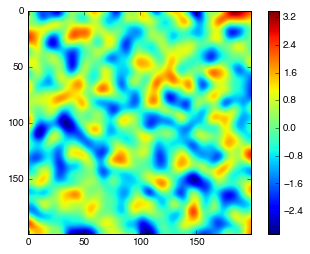

In [124]:
plt.figure(figsize=(6,4))
plt.imshow(zoomed[:,:,100])
plt.colorbar()
plt.show()

## Zoom in without interpolation

This is funny ! This is just an upsampled version with neirest neighbour.  The smoothness in voxel-space is **higher**, the smoothness in distance units would be **smaller**.

In [123]:
noint = np.zeros([200,200,200])
for m in range(200):
    for n in range(200):
        for o in range(200):
            ind = [int(x) for x in np.floor([m/2.,n/2.,o/2.])]
            noint[m,n,o] = data[ind[0],ind[1],ind[2]]

img=nib.Nifti1Image(noint,np.eye(4))
img.to_filename("noint.nii.gz")
maskim=nib.Nifti1Image(np.ones([200,200,200]),np.eye(4))
maskim.to_filename("mask.nii.gz")

cmd = "smoothest --mask=mask.nii.gz --zstat=noint.nii.gz > temp.txt"
os.popen(cmd)
smooth = open("temp.txt", 'r').read()
open("temp.txt", 'r').close()
fwhm = float(smooth.split("\n")[2].split(" ")[1])**(1/3.)
fwhm

8.625864087622388

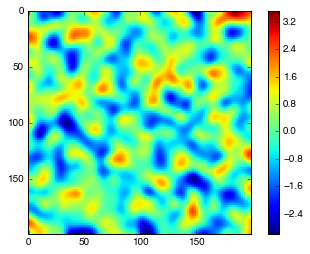

In [126]:
plt.figure(figsize=(6,4))
plt.imshow(noint[:,:,100])
plt.colorbar()
plt.show()